# Урок 4. CNN
## Домашнее задание
1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

Загрузка датасета CIFAR100

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

100%|██████████| 169001437/169001437 [00:12<00:00, 13039536.48it/s]


Extracting data/cifar-100-python.tar.gz to data/


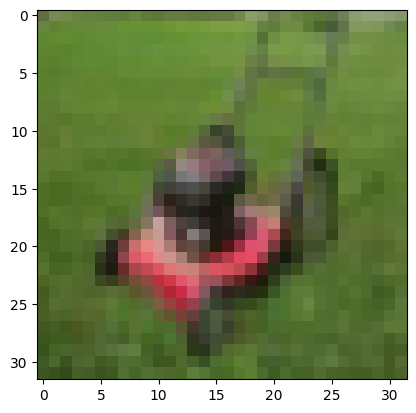

In [3]:
plt.imshow(dataset[500][0])
plt.show()

In [4]:
class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.1, random_state=13)
    return X_train, X_test

In [5]:
train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
test_dataset = MyOwnCifar(test_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=1024,
                          shuffle=True,
                          num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Рукописная сеть:
- три свёрточных слоя
- три полносвязных слоя
- батч-нормализация перед всеми слоями
- дропаут 0,4 перед двумя полносвязными слоями

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.4)
        self.dp_two = nn.Dropout(0.4)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 64, 3)
        self.bn_two = torch.nn.BatchNorm2d(64)
        self.conv_two = torch.nn.Conv2d(64, 128, 3)
        self.bn_three = torch.nn.BatchNorm2d(128)
        self.conv_three = torch.nn.Conv2d(128, 256, 3)
        self.bn_four = torch.nn.BatchNorm2d(256)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.out = torch.nn.Linear(256, 100)

    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.4, inplace=False)
  (dp_two): Dropout(p=0.4, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=100, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [9]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 30, 30]           1,792
       BatchNorm2d-3           [-1, 64, 15, 15]             128
            Conv2d-4          [-1, 128, 13, 13]          73,856
       BatchNorm2d-5            [-1, 128, 6, 6]             256
            Conv2d-6            [-1, 256, 4, 4]         295,168
       BatchNorm2d-7            [-1, 256, 2, 2]             512
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
           Linear-12                  [-1, 100]          25,700
Total params: 1,053,546
Trainable params: 1,053,546
Non-trainable params: 0
---------------------------

In [10]:
def learn_net(net, criterion, optimizer, num_epochs):
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
      running_loss = 0.0
      running_items = 0.0
      running_loss_test = 0.0
      running_items_test = 0.0
      running_right = 0.0
      running_right_test = 0.0

      net.train()
      for i, data in enumerate(train_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Обнуляем градиент
          optimizer.zero_grad()
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)
          # Делаем шаг назад по лоссу
          loss.backward()
          # Делаем шаг нашего оптимайзера
          optimizer.step()

          # выводим статистику о процессе обучения
          running_loss += loss.item()
          running_items += len(labels)
          running_right += (labels == torch.max(outputs, 1)[1]).sum()

      running_right = running_right.item()
      print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            f'Loss_train: {running_loss / (i + 1):.3f}. ' \
            f'Acc: {running_right / running_items:.3f}.', end=' ')
      acc = running_right / running_items
      train_acc.append(acc)
      # print(type(acc), acc, train_acc)
      running_loss, running_items, running_right = 0.0, 0.0, 0.0

      net.eval()
      for i, data in enumerate(test_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)

          running_loss_test += loss.item()
          running_items_test += len(labels)
          running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

      running_right_test = running_right_test.item()
      print(f'Loss_test: {running_loss_test / (i + 1):.3f}. ' \
            f'Acc_test: {running_right_test / running_items_test:.3f}')
      test_acc.append(running_right_test / running_items_test)
      running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0

  print('Training is finished!')

  return train_acc, test_acc

Обучение рукописной сети

In [ ]:
train_acc, test_acc = learn_net(net, criterion, optimizer, 50)

Epoch [1/50]. Loss_train: 4.095. Acc: 0.073. Loss_test: 3.983. Acc_test: 0.094
Epoch [2/50]. Loss_train: 3.712. Acc: 0.126. Loss_test: 4.309. Acc_test: 0.086
Epoch [3/50]. Loss_train: 3.504. Acc: 0.161. Loss_test: 3.954. Acc_test: 0.129
Epoch [4/50]. Loss_train: 3.350. Acc: 0.188. Loss_test: 3.965. Acc_test: 0.141
Epoch [5/50]. Loss_train: 3.239. Acc: 0.206. Loss_test: 3.695. Acc_test: 0.169
Epoch [6/50]. Loss_train: 3.151. Acc: 0.224. Loss_test: 3.664. Acc_test: 0.176
Epoch [7/50]. Loss_train: 3.074. Acc: 0.239. Loss_test: 3.924. Acc_test: 0.162
Epoch [8/50]. Loss_train: 3.006. Acc: 0.250. Loss_test: 3.525. Acc_test: 0.203
Epoch [9/50]. Loss_train: 2.963. Acc: 0.259. Loss_test: 3.495. Acc_test: 0.208
Epoch [10/50]. Loss_train: 2.908. Acc: 0.269. Loss_test: 3.454. Acc_test: 0.220
Epoch [11/50]. Loss_train: 2.870. Acc: 0.279. Loss_test: 3.238. Acc_test: 0.232
Epoch [12/50]. Loss_train: 2.837. Acc: 0.282. Loss_test: 3.409. Acc_test: 0.227
Epoch [13/50]. Loss_train: 2.802. Acc: 0.290. Los

Ошибка на трейне и тесте падает, точность растёт. Модель обучается нормально.

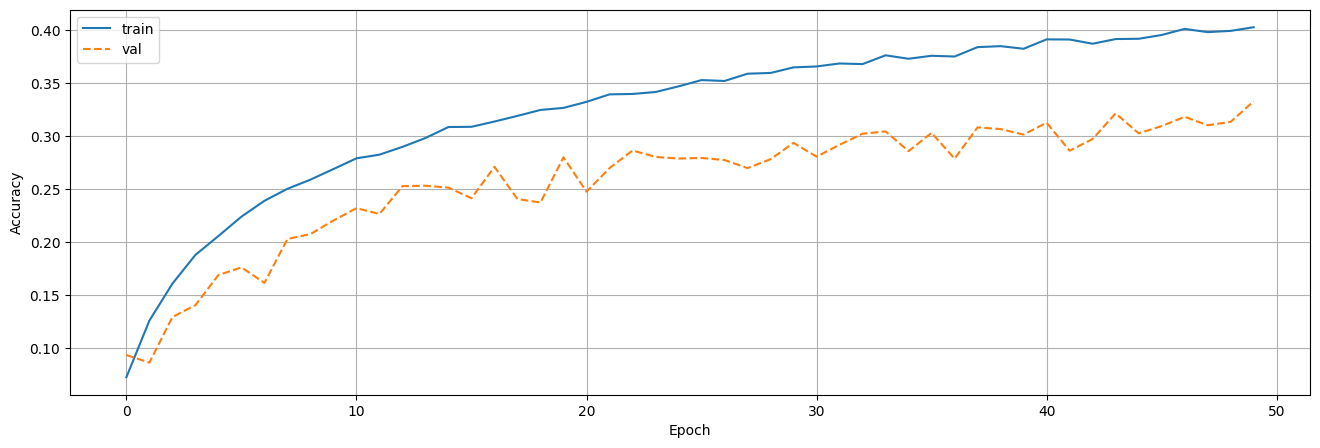

In [ ]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Загрузим предтренированую модель ResNet-50 для увеличения качества предсказания

In [11]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 289MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Веса всех слоёв оставим нетронутыми

In [13]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

Последний плотный слой изменим для классификации на 100 объектах

In [14]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

Итого количество настраиваемых параметров - 204,900. Это позволит значительно сократить время на обучение по сравнению с предыдущей моделью

In [15]:
resnet50 = resnet50.to(device)

Добавим аугментацию - увелчичим размер картинки до 256 и случайным образом вырежем необходимой размерности изменённую картинку 224х224 пикселя. По краям картику заполним нулями их 4х рядов.

In [16]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
test_dataset = MyOwnCifar(test_dataset, test_transforms)

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=512,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=2)

Выберем параметры, необходимые для оптимизации и передадим их оптимизатору

In [22]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.RMSprop(params_to_update, lr=0.002,momentum=0.98)
criterion = nn.CrossEntropyLoss()

In [23]:
%%time
train_acc, test_acc = learn_net(resnet50, criterion, optimizer, 30)

Epoch [1/30]. Loss_train: 277.731. Acc: 0.278. Loss_test: 276.068. Acc_test: 0.332
Epoch [2/30]. Loss_train: 199.750. Acc: 0.383. Loss_test: 134.820. Acc_test: 0.465
Epoch [3/30]. Loss_train: 95.859. Acc: 0.485. Loss_test: 64.059. Acc_test: 0.510
Epoch [4/30]. Loss_train: 40.690. Acc: 0.535. Loss_test: 36.370. Acc_test: 0.535
Epoch [5/30]. Loss_train: 28.181. Acc: 0.562. Loss_test: 30.755. Acc_test: 0.547
Epoch [6/30]. Loss_train: 23.956. Acc: 0.567. Loss_test: 26.022. Acc_test: 0.545
Epoch [7/30]. Loss_train: 20.479. Acc: 0.571. Loss_test: 24.580. Acc_test: 0.529
Epoch [8/30]. Loss_train: 18.516. Acc: 0.571. Loss_test: 22.658. Acc_test: 0.536
Epoch [9/30]. Loss_train: 17.054. Acc: 0.570. Loss_test: 20.463. Acc_test: 0.536
Epoch [10/30]. Loss_train: 16.280. Acc: 0.572. Loss_test: 21.520. Acc_test: 0.520
Epoch [11/30]. Loss_train: 14.765. Acc: 0.576. Loss_test: 19.865. Acc_test: 0.528
Epoch [12/30]. Loss_train: 14.414. Acc: 0.574. Loss_test: 19.069. Acc_test: 0.521
Epoch [13/30]. Loss_t

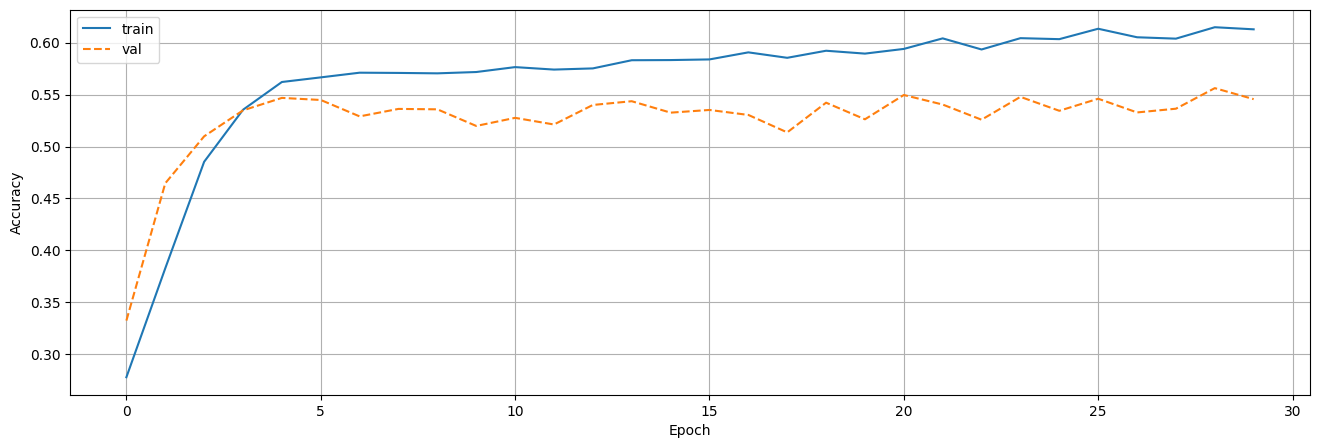

In [24]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Исспользование предобученной модели ResNet-50 позволило улучшить качество предсказания до значения ACC 0,54 на тестовой выборке.

Модель имеет некоторую степень переобучения по причине расхождения графиков значения оцениваемой метрики.